In [92]:
## personal imports
from processor.processor import Processor as p
from database.market import Market
from database.adatabase import ADatabase
from datetime import datetime

from tradealgorithm.tradealgorithm import TradeAlgorithm
from tradealgorithm.tradealgorithmfactory import TradeAlgorithmFactory
from pricer.pricer_factory import PricerFactory
from pricer.pricer import Pricer
from ranker.ranker_factory import RankerFactory
from ranker.ranker import Ranker
from classifier.classifier_factory import ClassifierFactory
from classifier.classifier import Classifier
from datetime import datetime

## risk and return class imports
from returns.products import Products as returns_products_class

## standard imports
from statistics import variance
import math
from datetime import datetime, timedelta
import pytz
import pandas as pd
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import pickle

In [93]:
start = datetime(2001,1,1)
end  = datetime(2023,1,1)
current_date = datetime(2023,1,1)

In [94]:
market = Market()

In [95]:
pricer_classes = [] 
pricer_classes.append(Pricer.DAILY_STOCK_MEANREVERSION)
pricer_classes.append(Pricer.DAILY_STOCK_DEVROLLING)
pricer_classes.append(Pricer.DAILY_STOCK_BREAKOUT)
pricer_classes.append(Pricer.DAILY_STOCK_WINDOW)
pricer_classes.append(Pricer.DAILY_STOCK_ROLLING)

In [96]:
market.connect()
sp500 = market.retrieve("sp500")
market.disconnect()
sp500 = sp500.rename(columns={"Symbol":"ticker"})

In [97]:
market.connect()
tyields = returns_products_class.tyields(market.retrieve("tyields10"),10)
bench_returns = returns_products_class.spy_bench(market.retrieve("spy"))
market.disconnect()
current = False
ranker_class = Ranker.NONE
classifier_class = Classifier.NONE

In [98]:
analysis = []
trade_algos = []
for pricer_class in tqdm(pricer_classes):
    trade_algo = TradeAlgorithmFactory.build(TradeAlgorithm.RRR_BETA)
    trade_algo.initialize(pricer_class,ranker_class,classifier_class,start,end,current_date)
    trade_algo.initialize_bench_and_yields()
    trade_algo.initialize_classes()
    trade_algos.append(trade_algo)
    trade_algo.db.connect()
    parameters = trade_algo.pull_iterations().to_dict("records")
    for parameter in tqdm(parameters):
        try:
            trade = trade_algo.db.query("trades",{"iteration":parameter["iteration"]})
            if trade.index.size > 0:
                positions = int(trade_algo.positions) if trade_algo.pricer_class.asset_class.value == "stocks" else 1
                pricer_timeframe =  trade_algo.pricer_class.time_horizon_class.naming_convention
                trade = trade[trade["position"] <= positions]
                ledger = trade.sort_values(["year",pricer_timeframe]).copy()
                anas = trade_algo.analysis
                if ledger.index.size > 0:
                    cumulative = anas.trade_analysis(ledger,positions,tyields,bench_returns)
                    for key in parameter.keys():
                        cumulative[key] = parameter[key]
                    cumulative["trade_algo"] = trade_algo.name
                    for key in parameter.keys():
                        cumulative[key] = parameter[key]
                    analysis.append(cumulative[list(parameter.keys()) + ["trade_algo","pv","beta","rrr","sharpe"]].iloc[-1])
        except Exception as e:
            print(str(e))
            continue
    trade_algo.db.disconnect()
a = pd.DataFrame([x.to_dict() for x in analysis])

 61%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                | 33/54 [00:16<00:13,  1.54it/s]


 33%|███████████████████████████████████████████████████████                                                                                                              | 18/54 [00:10<00:24,  1.46it/s]


  2%|███                                                                                                                                                                   | 1/54 [00:00<00:26,  1.97it/s]


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 43/54 [00:23<00:07,  1.49it/s]


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                             | 34/54 [00:16<00:12,  1.65it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:14<00:00, 26.90s/it]


In [99]:
a.sort_values("pv",ascending=False).head(20)

,value,ceiling,classification,rank,risk,floor_value,tyields,buy_day,iteration,trade_algo,pv,beta,rrr,sharpe
199,True,True,False,False,flat,5,tyield2,1,4,dsr_n_n_b_r,443.910454,-0.257202,0.760002,-1722.031303
200,True,True,False,False,flat,5,tyield10,1,5,dsr_n_n_b_r,443.910454,-0.257202,0.760002,-1722.031303
198,True,True,False,False,flat,5,tyield1,1,3,dsr_n_n_b_r,443.910454,-0.257202,0.760002,-1722.031303
222,True,False,False,False,flat,0,tyield1,1,27,dsr_n_n_b_r,443.910454,-0.257202,0.760002,-1722.031303
223,True,False,False,False,flat,0,tyield2,1,28,dsr_n_n_b_r,443.910454,-0.257202,0.760002,-1722.031303
224,True,False,False,False,flat,0,tyield10,1,29,dsr_n_n_b_r,443.910454,-0.257202,0.760002,-1722.031303
225,True,False,False,False,flat,5,tyield1,1,30,dsr_n_n_b_r,443.910454,-0.257202,0.760002,-1722.031303
226,True,False,False,False,flat,5,tyield2,1,31,dsr_n_n_b_r,443.910454,-0.257202,0.760002,-1722.031303
227,True,False,False,False,flat,5,tyield10,1,32,dsr_n_n_b_r,443.910454,-0.257202,0.760002,-1722.031303
228,True,False,False,False,flat,1,tyield1,1,33,dsr_n_n_b_r,443.910454,-0.257202,0.760002,-1722.031303


In [100]:
top_by_strategy = a.sort_values("pv",ascending=False).groupby("trade_algo").nth(0).reset_index().sort_values("pv",ascending=False)
top_by_strategy

,trade_algo,value,ceiling,classification,rank,risk,floor_value,tyields,buy_day,iteration,pv,beta,rrr,sharpe
3,dsr_n_n_b_r,True,True,False,False,flat,5,tyield2,1,4,443.910454,-0.257202,0.760002,-1722.031303
4,dsw_n_n_b_r,True,False,False,False,none,1,tyield10,1,53,422.072643,-0.256334,0.761053,-1642.669268
0,dsb_n_n_b_r,True,False,False,False,flat,0,tyield1,1,27,172.845941,-0.169401,0.842119,-1014.432984
1,dsdr_n_n_b_r,True,True,False,False,none,1,tyield2,1,25,136.101615,-0.111901,0.895738,-1207.329271
2,dsmr_n_n_b_r,True,False,False,False,flat,5,tyield10,1,32,0.992531,-6.203848,2.559113,0.001218


In [101]:
for row in top_by_strategy.iterrows():
    algo_name = row[1]["trade_algo"]
    parameter = row[1]
    db = ADatabase(algo_name)
    db.connect()
    db.drop("optimal")
    db.store("optimal",pd.DataFrame([row[1].to_dict()]))
    db.disconnect()
    db.cloud_connect()
    db.drop("optimal")
    db.store("optimal",pd.DataFrame([row[1].to_dict()]))
    db.disconnect()

In [102]:
top = a.sort_values("pv",ascending=False).iloc[0]
db = ADatabase(top["trade_algo"])
db.connect()
analysis = db.query("trades",{"iteration":int(top["iteration"])})
db.disconnect()

In [103]:
trade_algo_name = top["trade_algo"]
trade_algo_class = [x for x in trade_algos if x.name == trade_algo_name][0]
anas = trade_algo_class.analysis
naming = trade_algo_class.pricer_class.time_horizon_class.naming_convention
positions = int(int(analysis["position"].max()))
ledger = analysis[["year",naming,"ticker",f"{naming}ly_delta",f"{naming}ly_delta_sign","actual_returns","position"]]
ledger = ledger[(ledger["year"]>=start.year)]
ledger = ledger.merge(sp500[["ticker","GICS Sector","Security"]],on="ticker",how="left")

In [104]:
ledger

,year,date,ticker,dately_delta,dately_delta_sign,actual_returns,position,GICS Sector,Security
0,2001,2001-01-02,FFIV,1.050737,1.0,1.268293,0,Information Technology,"F5, Inc."
1,2001,2001-01-03,FFIV,0.845171,1.0,1.134615,0,Information Technology,"F5, Inc."
2,2001,2001-01-04,EIX,0.422816,1.0,0.959070,0,Utilities,Edison International
3,2001,2001-01-05,EIX,0.567535,1.0,1.163919,0,Utilities,Edison International
4,2001,2001-02-20,GLW,0.495045,1.0,1.008319,0,Information Technology,Corning Inc.
...,...,...,...,...,...,...,...,...,...
32505,2023,2023-05-26,AES,0.081654,1.0,1.001510,19,Utilities,AES Corporation
32506,2023,2023-05-30,AES,0.077806,1.0,0.991960,19,Utilities,AES Corporation
32507,2023,2023-05-31,BAX,0.075156,1.0,1.019646,19,Health Care,Baxter International
32508,2023,2023-06-01,SWK,0.082583,1.0,1.070791,19,Industrials,Stanley Black & Decker


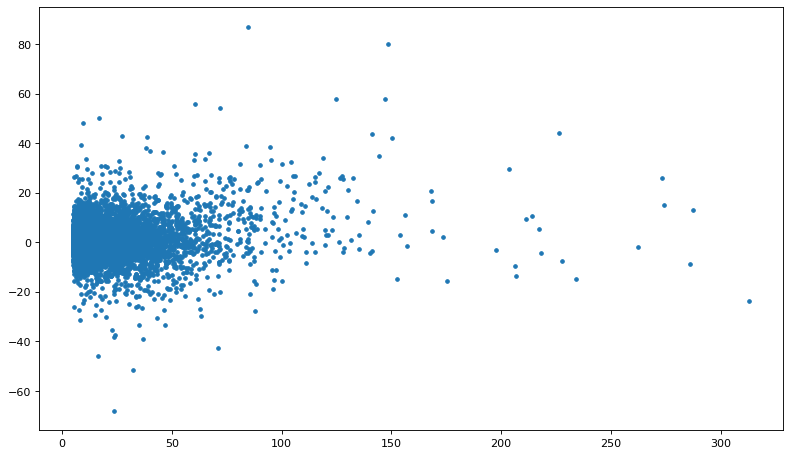

In [105]:
plt.figure(figsize=(12, 7), dpi=80)
plt.scatter(ledger[f"{naming}ly_delta"] * 100, (ledger["actual_returns"]-1)*100,s=10)

In [106]:
ledger.sort_values(["year",naming,"position"],ascending=True).head(40)

,year,date,ticker,dately_delta,dately_delta_sign,actual_returns,position,GICS Sector,Security
0,2001,2001-01-02,FFIV,1.050737,1.0,1.268293,0,Information Technology,"F5, Inc."
2188,2001,2001-01-02,AKAM,0.375760,1.0,1.227848,1,Information Technology,Akamai
4357,2001,2001-01-02,DLTR,0.317551,1.0,1.089565,2,Consumer Discretionary,Dollar Tree
6483,2001,2001-01-02,AMZN,0.308194,1.0,1.265130,3,Consumer Discretionary,Amazon
8556,2001,2001-01-02,BKNG,0.306107,1.0,1.283688,4,Consumer Discretionary,Booking Holdings
10564,2001,2001-01-02,ILMN,0.267621,1.0,0.905574,5,Health Care,Illumina
12495,2001,2001-01-02,GLW,0.204920,1.0,1.170114,6,Information Technology,Corning Inc.
14347,2001,2001-01-02,VRSN,0.203505,1.0,1.304158,7,Information Technology,Verisign
16119,2001,2001-01-02,SWKS,0.198324,1.0,1.068034,8,Information Technology,Skyworks Solutions
17800,2001,2001-01-02,NVDA,0.196369,1.0,1.306947,9,Information Technology,Nvidia


In [107]:
ledger[ledger["position"]<20].sort_values("actual_returns",ascending=False).head(50)

,year,date,ticker,dately_delta,dately_delta_sign,actual_returns,position,GICS Sector,Security
14956,2008,2008-10-10,MS,0.846386,1.0,1.869835,7,Financials,Morgan Stanley
758,2008,2008-10-28,LVS,1.485776,1.0,1.800000,0,Consumer Discretionary,Las Vegas Sands
7227,2008,2008-11-21,C,1.247784,1.0,1.578249,3,Financials,Citigroup
761,2008,2008-10-31,HIG,1.469802,1.0,1.577519,0,Financials,Hartford (The)
17,2001,2001-04-06,EQIX,0.605825,1.0,1.559322,0,Real Estate,Equinix
16699,2008,2008-10-13,KEY,0.721060,1.0,1.542526,8,Financials,KeyCorp
30714,2008,2008-12-03,DXCM,0.168500,1.0,1.502513,18,Health Care,Dexcom
11277,2009,2009-04-02,MGM,0.093536,1.0,1.480892,5,Consumer Discretionary,MGM Resorts
1865,2020,2020-03-23,CZR,2.263209,1.0,1.441571,0,Consumer Discretionary,Caesars Entertainment
5116,2008,2008-11-24,LNC,1.411164,1.0,1.436700,2,Financials,Lincoln Financial


In [108]:
ledger["actual_returns"].mean()

1.003119580572682

In [109]:
ledger[ledger["actual_returns"]>1].index.size / ledger.index.size

0.5234697016302676

In [110]:
portfolio = ledger.pivot_table(index=["year",naming],columns="position",values="actual_returns").fillna(1).reset_index()

In [111]:
portfolio.head(20)

position,year,date,0,1,2,3,4,5,6,7,...,10,11,12,13,14,15,16,17,18,19
0,2001,2001-01-02,1.268293,1.227848,1.089565,1.265130,1.283688,0.905574,1.170114,1.304158,...,0.816667,1.240168,0.969932,1.105118,1.016854,1.026103,1.077517,1.084913,1.102061,1.130042
1,2001,2001-01-03,1.134615,0.861031,0.953728,0.882688,1.000000,0.877893,0.921757,0.927684,...,0.996573,1.023172,1.115001,0.949242,0.939091,1.035330,1.071823,0.877551,0.898882,0.967849
2,2001,2001-01-04,0.959070,0.845011,0.792542,1.104972,0.879457,0.938835,1.085455,0.931034,...,0.974524,0.922266,0.916098,0.896390,0.939355,0.895031,0.981447,0.874642,0.958140,0.907821
3,2001,2001-01-05,1.163919,0.985000,0.986600,0.743300,1.022605,0.958333,0.925212,1.026099,...,0.962144,0.924722,1.031998,1.026212,1.007035,1.016729,0.962330,1.006646,1.032576,1.022611
4,2001,2001-02-20,1.008319,0.943881,0.913242,0.922078,1.001739,0.906061,0.931052,0.877664,...,0.964313,1.020220,0.955200,0.900195,0.974146,0.994380,0.989289,0.971625,0.983636,0.946995
5,2001,2001-02-21,1.039934,1.020000,0.976597,0.922592,0.985427,0.914396,0.947603,0.985000,...,1.000000,1.000000,1.067402,0.949497,1.019783,0.874062,1.000220,0.971891,1.043761,0.954745
6,2001,2001-02-22,1.053634,0.953895,1.007572,1.044689,1.071945,1.128824,1.000000,1.003845,...,0.989112,1.091719,0.980292,1.035714,0.972001,0.938568,0.939850,0.939850,1.009888,1.024921
7,2001,2001-02-23,1.015152,1.045336,1.088655,0.978012,1.000000,0.967005,0.964950,0.971192,...,1.146915,0.972304,1.000000,1.011008,1.028160,0.862069,1.020223,0.965185,1.043911,0.966833
8,2001,2001-03-26,1.037037,0.956836,1.135082,1.121298,1.022749,0.932896,0.993131,0.984127,...,0.810000,1.059815,1.062376,0.992833,1.067518,1.030303,0.990000,1.061728,0.980170,1.067355
9,2001,2001-03-27,0.924547,0.971559,0.909879,1.024454,0.970588,1.013580,0.891271,0.962963,...,0.978866,0.933057,0.947977,0.913222,0.940000,0.905724,0.868726,0.891879,0.977060,0.912804


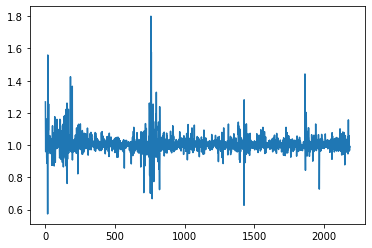

In [112]:
plt.plot(portfolio[0])

In [113]:
positions = 20

In [114]:
cumulative = anas.iteration_analysis(portfolio,positions,bench_returns)

In [115]:
anas.naming

'date'

In [116]:
cumulative.tail(10)

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,year,date,pv,daily_returns,adjclose,bench
2178,6673.836944,142.330139,12.242621,856.424847,1097.170539,12.785297,103.351462,10.632758,204.547681,49.898209,...,38.555349,12.063216,41.276254,10.887817,2023,2023-05-19,468.107059,1.011497,12284.74,4.926666
2179,6642.671595,143.764598,11.873339,842.429645,1097.170539,13.183323,103.392345,10.576364,202.842170,50.722973,...,38.968506,11.800458,40.786888,10.914953,2023,2023-05-22,465.767250,0.993197,12365.21,4.958938
2180,6518.010197,138.823686,11.819856,814.896362,1054.115133,13.208837,100.030195,10.407103,203.188252,50.559351,...,38.959591,11.508736,40.022475,10.823813,2023,2023-05-23,455.461705,0.982952,12343.05,4.950051
2181,6268.687403,132.014895,11.731444,773.739980,1055.604229,13.189933,100.667598,10.115873,193.255379,48.571337,...,37.955653,11.320993,39.803631,10.859140,2023,2023-05-24,440.013957,0.982372,12500.57,5.013222
2182,6638.219402,138.334757,12.134818,780.325001,1055.898872,13.610889,107.948588,10.125830,193.255379,48.591874,...,37.822172,11.174605,39.868715,11.201854,2023,2023-05-25,459.590758,1.015312,12688.84,5.088726
2183,6671.915947,134.732688,12.907995,758.577790,1042.977032,13.385169,107.879620,10.218621,190.873672,49.958734,...,39.113343,11.179587,38.949077,11.218767,2023,2023-05-26,459.350772,1.000441,12657.90,5.076318
2184,6633.554858,134.732688,12.643668,768.904962,1030.708283,13.094144,106.603537,9.799825,185.768344,49.275304,...,39.356913,11.075334,39.371926,11.128566,2023,2023-05-30,456.865697,0.991611,12560.25,5.037156
2185,6536.438178,133.167849,12.452097,770.255670,1079.511240,12.577678,107.839902,9.979577,182.891635,48.889859,...,39.557662,11.139620,40.847509,11.347202,2023,2023-05-31,454.412701,1.003418,12484.16,5.006641
2186,6491.279778,139.291532,13.256874,782.353312,1112.726970,12.970852,111.812051,10.410735,187.953573,51.008120,...,40.224555,11.261049,42.294397,12.150478,2023,2023-06-01,455.716176,1.032713,12698.09,5.092436
2187,6301.998825,133.212410,13.213249,762.620278,1100.445216,12.325536,109.613075,10.461090,183.454406,50.252875,...,39.527239,11.431102,42.220441,12.211336,2023,2023-06-02,443.910454,0.987652,12975.69,5.203764


In [117]:
cash_analysis = cumulative.copy()
cash_analysis["previous_day"] = cash_analysis["daily_returns"].shift(1)
cash_analysis["base"] = [min(row[1]["previous_day"],1) for row in cash_analysis.iterrows()]
cash_analysis["real_return"] = cash_analysis["base"] * cash_analysis["daily_returns"]
cash_analysis["cash"] = [max(0,row[1]["real_return"]-1) * 100 for row in cash_analysis.iterrows()]
cash_analysis["running_cash"] = cash_analysis["cash"].cumsum()

In [118]:
cash_analysis["cash"].sum()

1209.210849998528

In [119]:
cash_analysis[["daily_returns","base","real_return","cash","running_cash"]]

,daily_returns,base,real_return,cash,running_cash
0,1.122936,NaN,NaN,0.000000,0.000000
1,0.974245,1.000000,0.974245,0.000000,0.000000
2,0.930929,0.974245,0.906952,0.000000,0.000000
3,0.979849,0.930929,0.912169,0.000000,0.000000
4,0.961355,0.979849,0.941983,0.000000,0.000000
...,...,...,...,...,...
2183,1.000441,1.000000,1.000441,0.044121,1205.939595
2184,0.991611,1.000000,0.991611,0.000000,1205.939595
2185,1.003418,0.991611,0.995000,0.000000,1205.939595
2186,1.032713,1.000000,1.032713,3.271255,1209.210850


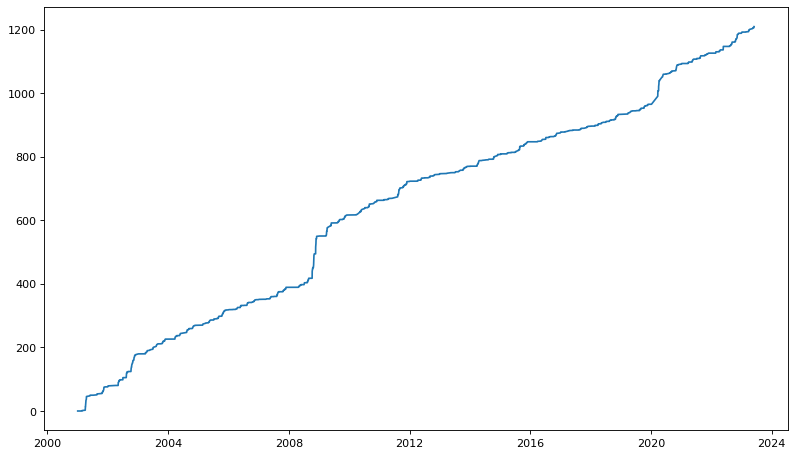

In [120]:
plt.figure(figsize=(12, 7), dpi=80)
plt.plot(cash_analysis["date"],cash_analysis["running_cash"])

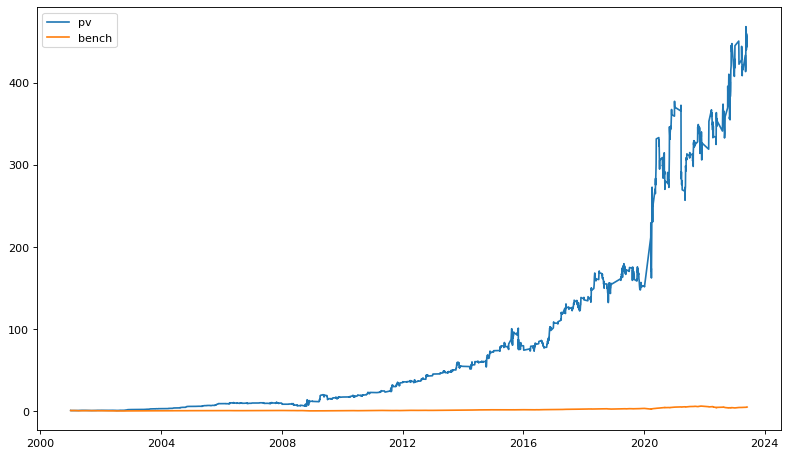

In [121]:
plt.figure(figsize=(12, 7), dpi=80)
plt.plot(cumulative["date"],cumulative["pv"])
plt.plot(cumulative["date"],cumulative["bench"])
plt.legend(["pv","bench"])

In [122]:
cumulative.head(20)

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,year,date,pv,daily_returns,adjclose,bench
0,1.268293,1.227848,1.089565,1.265130,1.283688,0.905574,1.170114,1.304158,1.068034,1.306947,...,1.077517,1.084913,1.102061,1.130042,2001,2001-01-02,1.122936,1.122936,2493.52,1.000000
1,1.439024,1.057215,1.039149,1.116715,1.283688,0.794997,1.078561,1.209846,1.082770,1.355549,...,1.154908,0.952066,0.990622,1.093710,2001,2001-01-03,1.093968,0.974245,2539.35,1.018380
2,1.380125,0.893358,0.823569,1.233939,1.128949,0.746371,1.170728,1.126409,0.984402,1.229931,...,1.133481,0.832717,0.949155,0.992893,2001,2001-01-04,1.018417,0.930929,2557.76,1.025763
3,1.606353,0.879958,0.812533,0.917187,1.154468,0.715272,1.083172,1.155807,0.915074,1.061843,...,1.090782,0.838251,0.980074,1.015344,2001,2001-01-05,0.996444,0.979849,2470.52,0.990776
4,1.619717,0.830575,0.742039,0.845717,1.156476,0.648080,1.008489,1.014410,0.936182,1.061843,...,1.079099,0.814466,0.964036,0.961525,2001,2001-02-20,0.960458,0.961355,2427.72,0.973612
5,1.684399,0.847186,0.724674,0.780252,1.139623,0.592602,0.955648,0.999194,0.984984,1.075267,...,1.079336,0.791572,1.006224,0.918011,2001,2001-02-21,0.951189,0.986884,2491.40,0.999150
6,1.774739,0.808127,0.730161,0.815121,1.221613,0.668943,0.955648,1.003036,1.000333,1.098041,...,1.014414,0.743958,1.016173,0.940889,2001,2001-02-22,0.963071,1.011154,2552.91,1.023818
7,1.801629,0.844764,0.794893,0.797198,1.221613,0.646871,0.922152,0.974141,1.090993,1.235296,...,1.034929,0.718058,1.060794,0.909682,2001,2001-02-23,0.976099,1.013127,2425.38,0.972673
8,1.868356,0.808301,0.902269,0.893897,1.249403,0.603463,0.915818,0.958678,1.079325,1.202185,...,1.024579,0.762382,1.039759,0.970954,2001,2001-03-26,0.989927,1.013388,1951.18,0.782500
9,1.727384,0.785312,0.820955,0.915756,1.212656,0.611658,0.816241,0.923171,1.053354,1.160410,...,0.890079,0.679953,1.015907,0.886291,2001,2001-03-27,0.933324,0.943967,1857.44,0.744907


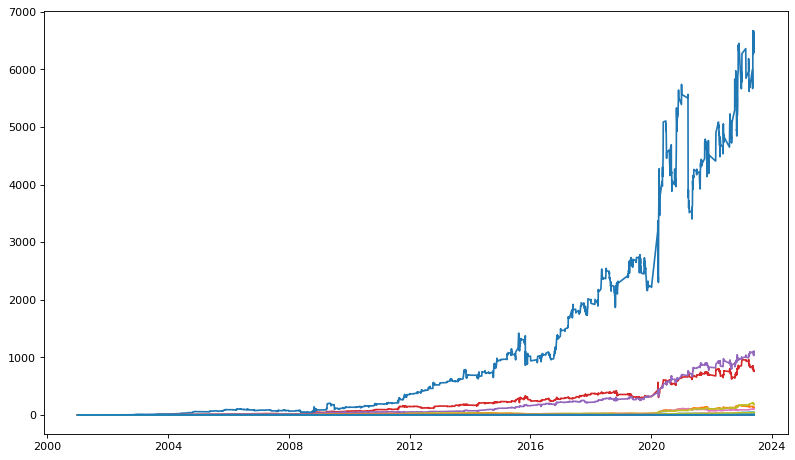

In [123]:
plt.figure(figsize=(12, 7), dpi=80)
position_columns = [x for x in cumulative.columns if x not in ["year","week","quarter","date_string","date","pv","adjclose","bench"]]
for i in position_columns:
    position = cumulative[i]
    plt.plot(cumulative["date"],position)
plt.show()


In [124]:
ledger.groupby(["GICS Sector"]).mean().sort_values("actual_returns",ascending=False)

,year,dately_delta,dately_delta_sign,actual_returns,position
GICS Sector,,,,,
Financials,2011.314510,0.137723,1.0,1.004483,9.458899
Real Estate,2009.192611,0.165003,1.0,1.004175,8.596002
Utilities,2011.258493,0.118097,1.0,1.003986,9.215657
Consumer Discretionary,2012.845427,0.125147,1.0,1.003908,8.115350
Industrials,2011.798987,0.122288,1.0,1.003222,8.362456
Information Technology,2011.318209,0.123641,1.0,1.002968,7.803534
Health Care,2010.481405,0.119332,1.0,1.002724,7.614576
Energy,2013.859545,0.113287,1.0,1.002439,9.207221
Materials,2013.299072,0.111181,1.0,1.002411,8.860080


In [125]:
ledger.groupby(["year",naming,"ticker","Security"]).prod().sort_values("actual_returns",ascending=False).head(30)

dately_delta  \
year date       ticker Security                                       
2008 2008-10-10 MS     Morgan Stanley                      0.846386   
     2008-10-28 LVS    Las Vegas Sands                     1.485776   
     2008-11-21 C      Citigroup                           1.247784   
     2008-10-31 HIG    Hartford (The)                      1.469802   
2001 2001-04-06 EQIX   Equinix                             0.605825   
2008 2008-10-13 KEY    KeyCorp                             0.721060   
     2008-12-03 DXCM   Dexcom                              0.168500   
2009 2009-04-02 MGM    MGM Resorts                         0.093536   
2020 2020-03-23 CZR    Caesars Entertainment               2.263209   
2008 2008-11-24 LNC    Lincoln Financial                   1.411164   
     2008-11-12 CBRE   CBRE Group                          0.272115   
2002 2002-11-14 ALGN   Align Technology                    0.387692   
2020 2020-03-23 NCLH   Norwegian Cruise Line Holdings      1.504989   
2002 2002-10-30 AES    AES Corporation                     0.085484   
2020 2020-03-23 BBWI   Bath & Body Works, Inc.             0.837628   
2008 2008-10-10 PRU    Prudential Financial                0.947460   
2020 2020-04-03 CZR    Caesars Entertainment               0.380506   
2008 2008-10-30 LVS    Las Vegas Sands                     0.401852   
2003 2003-01-06 EQIX   Equinix                             0.460433   
2002 2002-10-09 NFLX   Netflix                             0.670229   
2008 2008-10-27 AIG    American International Group        0.604118   
2020 2020-03-23 PENN   Penn National Gaming                1.442142   
2008 2008-10-13 HIG    Hartford (The)                      1.186297   
     2008-11-21 KIM    Kimco Realty                        0.652709   
2001 2001-04-06 AMZN   Amazon                              0.110197   
2020 2020-03-23 MGM    MGM Resorts                         0.953139   
2008 2008-10-28 MGM    MGM Resorts                         0.601741   
2009 2009-04-07 LNC    Lincoln Financial                   0.258307   
2008 2008-11-25 LYV    Live Nation Entertainment           1.041236   
2020 2020-03-23 LNC    Lincoln Financial                   1.000234   

                                                       dately_delta_sign  \
year date       ticker Security                                            
2008 2008-10-10 MS     Morgan Stanley                                1.0   
     2008-10-28 LVS    Las Vegas Sands                               1.0   
     2008-11-21 C      Citigroup                                     1.0   
     2008-10-31 HIG    Hartford (The)                                1.0   
2001 2001-04-06 EQIX   Equinix                                       1.0   
2008 2008-10-13 KEY    KeyCorp                                       1.0   
     2008-12-03 DXCM   Dexcom                                        1.0   
2009 2009-04-02 MGM    MGM Resorts                                   1.0   
2020 2020-03-23 CZR    Caesars Entertainment                         1.0   
2008 2008-11-24 LNC    Lincoln Financial                             1.0   
     2008-11-12 CBRE   CBRE Group                                    1.0   
2002 2002-11-14 ALGN   Align Technology                              1.0   
2020 2020-03-23 NCLH   Norwegian Cruise Line Holdings                1.0   
2002 2002-10-30 AES    AES Corporation                               1.0   
2020 2020-03-23 BBWI   Bath & Body Works, Inc.                       1.0   
2008 2008-10-10 PRU    Prudential Financial                          1.0   
2020 2020-04-03 CZR    Caesars Entertainment                         1.0   
2008 2008-10-30 LVS    Las Vegas Sands                               1.0   
2003 2003-01-06 EQIX   Equinix                                       1.0   
2002 2002-10-09 NFLX   Netflix                                       1.0   
2008 2008-10-27 AIG    American International Group                  1.0   
2020 2020-03-23 PENN   Penn Nation

In [126]:
industry_analysis = ledger.pivot_table(index=["year",naming],columns="GICS Sector",values="actual_returns").fillna(1).reset_index()
industry_analysis[[x for x in industry_analysis.columns if x != "sell_date"]].cumprod()

GICS Sector,year,date,Communication Services,Consumer Discretionary,Consumer Staples,Energy,Financials,Health Care,Industrials,Information Technology,Materials,Real Estate,Utilities
0,2001,2001-01-02 00:00:00.000000000,1.000000,1.152079,1.000000,1.000000,1.000000,0.905574,1.084913,1.168867,1.000000,1.016854,0.816667
1,4004001,2252-06-29 23:17:13.297436672,1.000000,1.074684,1.000000,1.000000,1.000000,0.926557,1.050032,1.157669,1.000000,1.016854,0.716667
2,8012006001,2159-09-27 04:21:44.589074432,1.000000,1.074445,1.000000,1.000000,0.907821,0.837437,1.050032,1.035556,1.000000,1.123596,0.695352
3,16032024008001,1970-01-01 00:00:00.000000000,1.000000,1.081267,1.000000,1.000000,0.923008,0.773215,1.050032,1.001380,1.000000,1.106742,0.730312
4,32080080040010001,1970-01-01 00:00:00.000000000,1.000000,1.032826,0.989289,0.974146,0.896818,0.729822,1.050032,0.964166,1.000000,1.010723,0.730312
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2183,0,1970-01-01 00:00:00.000000000,6.277328,226.553229,2.031304,2.291728,22.295881,34.396530,17.055231,389.725733,12.611683,9.177175,2.218804
2184,0,1970-01-01 00:00:00.000000000,6.187869,222.468080,2.031304,2.291728,22.295881,34.507591,17.055231,389.725733,12.469459,9.177175,2.235152
2185,0,1970-01-01 00:00:00.000000000,6.160191,220.496897,2.031304,2.291728,22.295881,35.233962,17.055231,389.725733,12.596644,9.177175,2.215525
2186,0,1970-01-01 00:00:00.000000000,6.349735,227.827634,2.031304,2.291728,22.538920,36.200380,18.262582,389.725733,12.996715,9.177175,2.215525
